In [492]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [493]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
#df.describe(include="all").T
df.head(2)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product


### Exploratory Data Analysis (EDA) 
EDA is going to help us inanalyzing and summarizing our data set's main characteristics. Also, to identify underlying structure of our data, to spot anomalies and outliers, to test underlying assumptions, and to form hypotheses that can be further tested.

In [494]:
# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [495]:
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

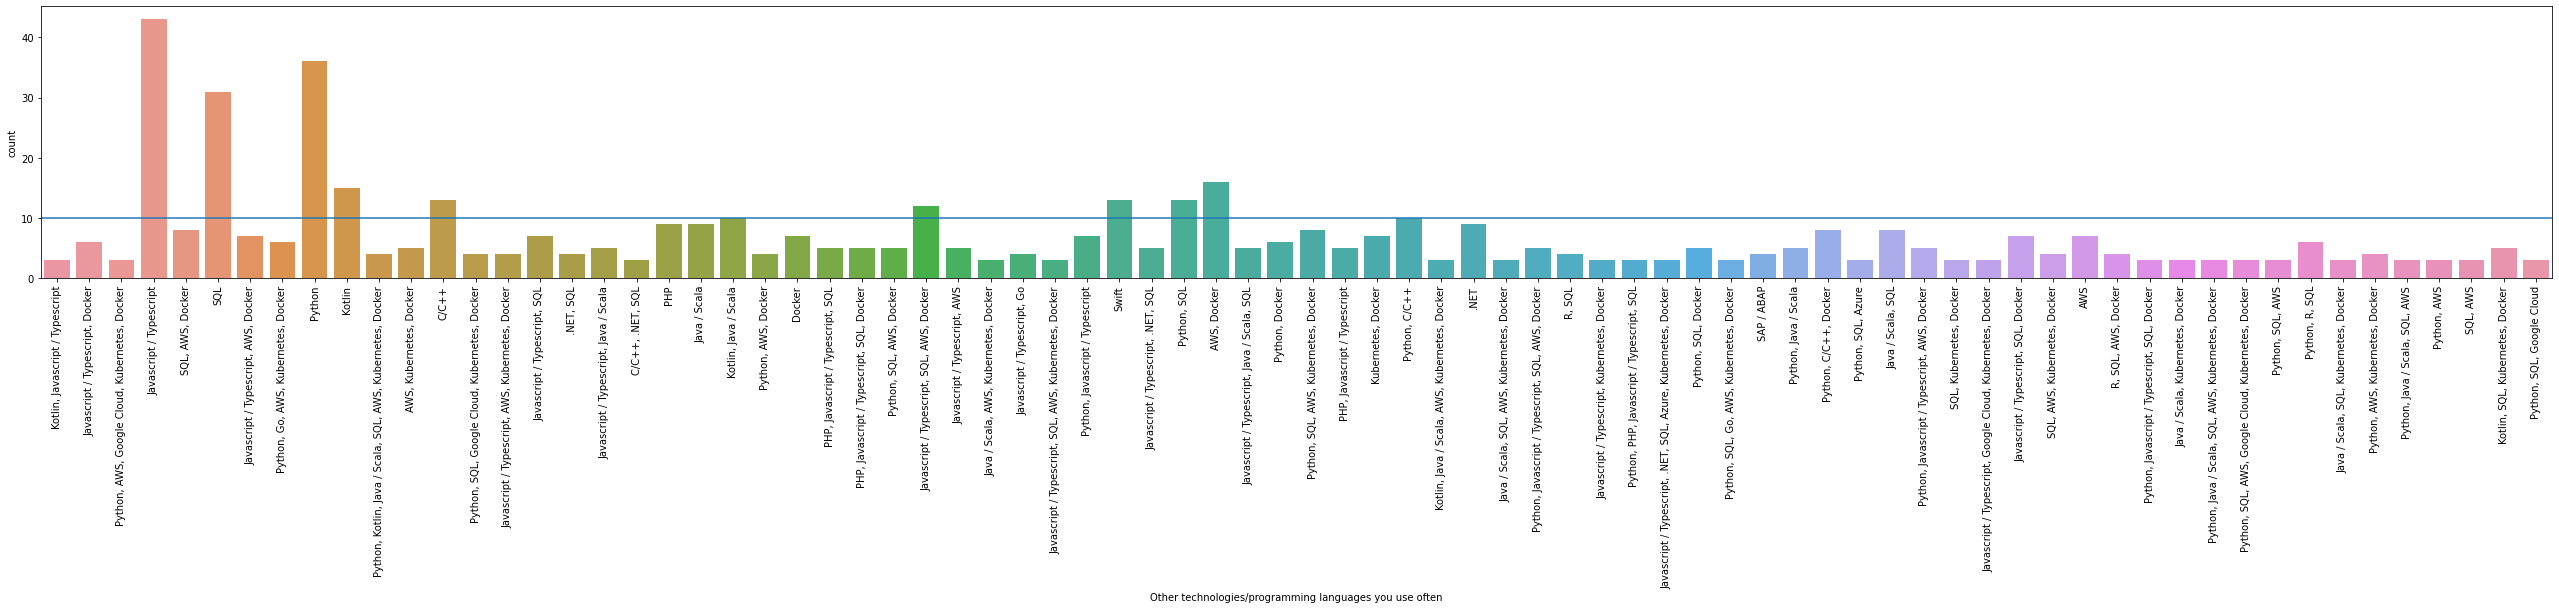

In [496]:
# Construct a temporary dataset with things that have > 2 records
# remove outliers
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(10)
ax.tick_params(axis='x', rotation=90)

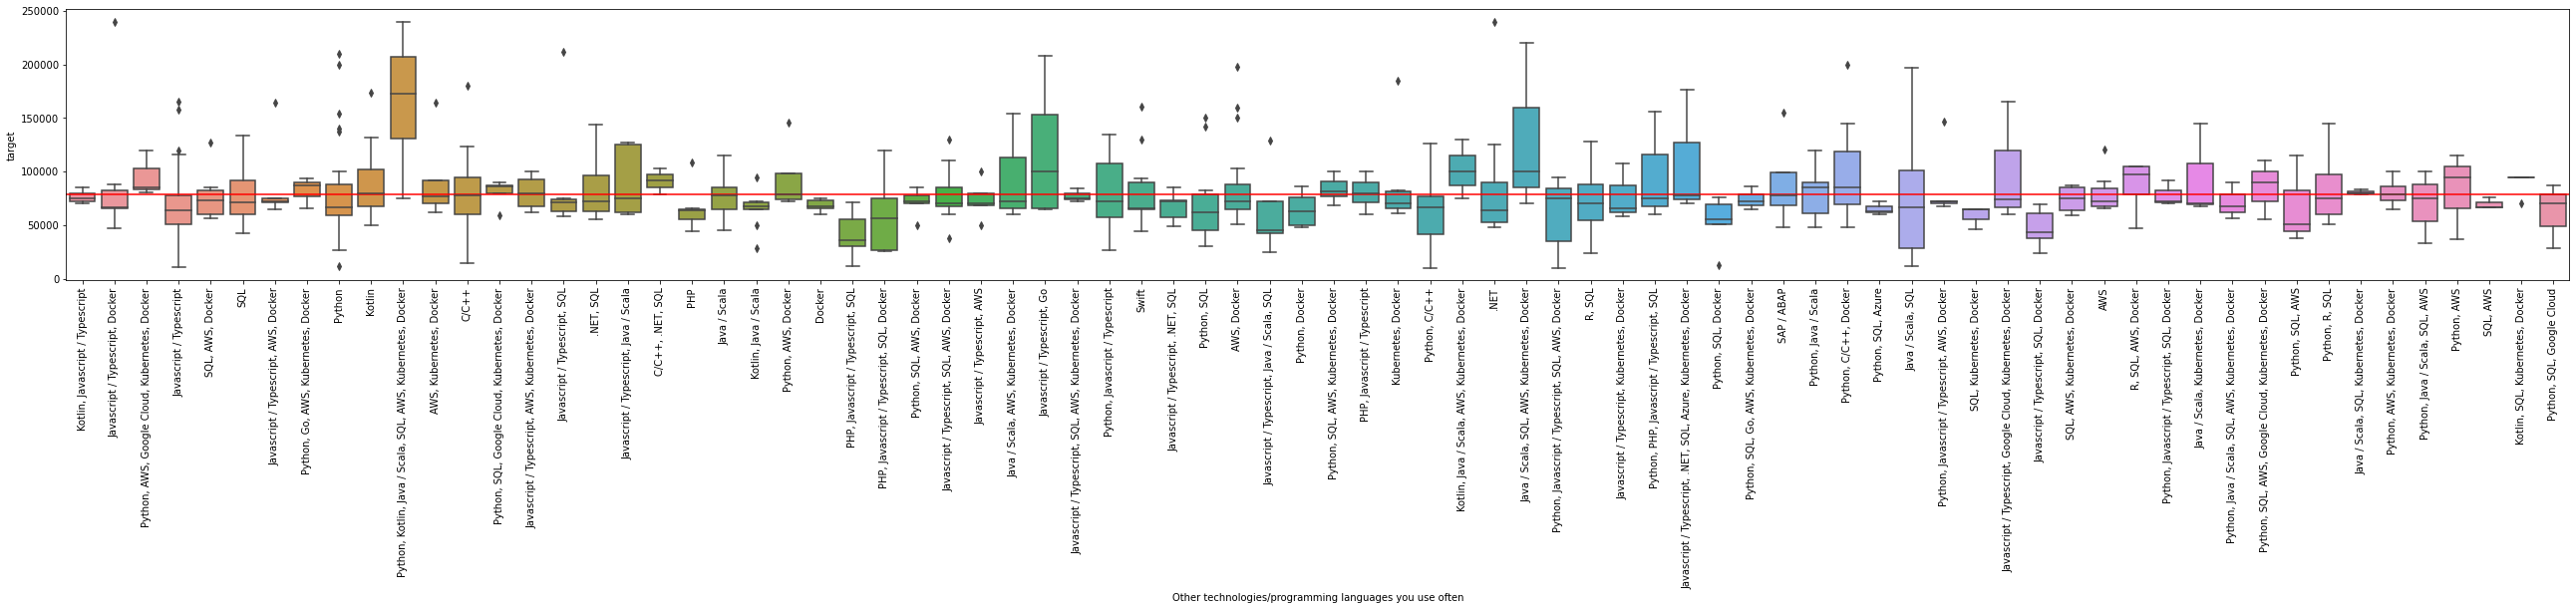

In [497]:
plt.figure(figsize=(45,5))
ax = sns.boxplot(x="Other technologies/programming languages you use often", y="target", data=df_tmp)
ax.axhline(df_tmp["target"].mean(), color="red")
ax.tick_params(axis='x', rotation=90)

##  function to replace less frequent values in columns within our dataframe

In [498]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [499]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts()

Other         377
Java          184
Python        164
PHP            56
C++            38
JavaScript     34
Javascript     31
C#             30
python         26
Swift          24
Scala          24
Go             23
Kotlin         22
Python         21
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [500]:
## Correlation Matrix
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\shikh\AppData\Local\Temp\ipykernel_39648\527883699.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,Age,target
Age,1.00,-0.02
target,-0.02,1.00


In [501]:
df.describe()

,Age,target
count,1226.000000,1.253000e+03
mean,32.509788,8.428361e+07
std,5.663804,2.829182e+09
min,20.000000,1.000100e+04
25%,29.000000,6.000000e+04
50%,32.000000,7.400000e+04
75%,35.000000,9.100000e+04
max,69.000000,1.000000e+11


In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1226 non-null   float64
 1   Gender                                                  1243 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1247 non-null   object 
 4   Total years of experience                               1237 non-null   object 
 5   Years of experience in Germany                          1221 non-null   object 
 6   Seniority level                                         1241 non-null   object 
 7   Your main technology / programming language             1126 non-null   object 
 8   Other technologies/programming languag

## DROPING FOLLOWING COLUMN:
<br>-Total years of experience as it is associated with Seniority Level
<br>-Number of Vacations
<br>-Employment statues- Due to less variance
<br>-'Other technologies/programming languages you use often'

In [503]:
df.drop(['Other technologies/programming languages you use often'], axis=1, inplace=True)

In [504]:
df.drop(["Number of vacation days"],axis=1,inplace=True)

In [505]:
df.drop('Total years of experience', axis=1, inplace = True)

In [506]:
df.drop(['Employment status'], axis=1,inplace = True)

In [507]:
df.drop(['Сontract duration'], axis=1, inplace= True)

## Changing type of following columns:

### <br>-'Years of experience in Germany'


In [508]:
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(pd.to_numeric, downcast='float', errors='coerce')

### A function for Replacing ','(commans) in column with '.' with in our dataframe

In [509]:
def replace_comma(df, column_name):
    for i, row in df.iterrows():
        value = row[column_name]
        if isinstance(value, str):
            df.at[i, column_name] = value.replace(',','.')
        else:
            df.at[i, column_name] = value

In [510]:
replace_comma(df,  'Years of experience in Germany')

In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Age                                          1226 non-null   float64
 1   Gender                                       1243 non-null   object 
 2   City                                         1253 non-null   object 
 3   Position                                     1247 non-null   object 
 4   Years of experience in Germany               1194 non-null   float64
 5   Seniority level                              1241 non-null   object 
 6   Your main technology / programming language  1126 non-null   object 
 7   Main language at work                        1237 non-null   object 
 8   Company size                                 1235 non-null   object 
 9   Company type                                 1228 non-null   object 
 10  

## A function to find categorical data and numerical data

In [512]:
def find_categorical_numerical(df):
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical.append(col)
        else:
            numerical.append(col)
    return categorical, numerical

In [513]:
categorical, numerical = find_categorical_numerical(df)

In [514]:
print("Numerical data:")
numerical

Numerical data:


['Age', 'Years of experience in Germany', 'target']

In [515]:
print("Categorical Data:")
categorical

Categorical Data:


['Gender',
 'City',
 'Position ',
 'Seniority level',
 'Your main technology / programming language',
 'Main language at work',
 'Company size',
 'Company type']

## Function to define outliers

In [516]:
#Defining outliers
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in numerical:
    print(col, check_outlier(df, col))
#person_age, person_income and person_emp_lenght have some outlier observations

Age False
Years of experience in Germany False
target True


## Defining the thresholds for outliers

In [517]:
outlier_thresholds(df, numerical)

(Age                                  -16.000
 Years of experience in Germany       -28.605
 target                           -381740.000
 dtype: float64,
 Age                                   88.000
 Years of experience in Germany        47.675
 target                            694900.000
 dtype: float64)

### Replacing Outliers:
The presence of outliers can impact the accuracy and reliability of the results of any analysis or modeling performed on the dataset. It is therefore important to handle outliers appropriately.

In [518]:

#Replacing Outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > (up_limit)), variable] = up_limit

for col in numerical:
    replace_with_thresholds(df, col)

#Check
for col in numerical:
    print(col, check_outlier(df, col))

Age False
Years of experience in Germany False
target False


In [519]:
df.describe()

,Age,Years of experience in Germany,target
count,1226.000000,1194.000000,1253.000000
mean,32.509788,3.757956,86156.628556
std,5.663804,3.656551,57188.117316
min,20.000000,0.000000,10001.000000
25%,29.000000,1.000000,60000.000000
50%,32.000000,3.000000,74000.000000
75%,35.000000,5.000000,91000.000000
max,69.000000,30.000000,694900.000000


### creating pairplot- 

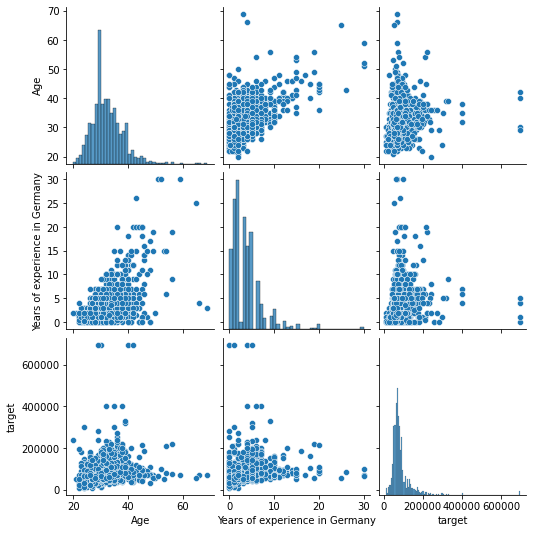

In [520]:
sns.pairplot(df)

### -RESULT OF REMOVEL OF OUTLIERS-

## Categorical Plotting


<AxesSubplot:xlabel='Gender', ylabel='target'>

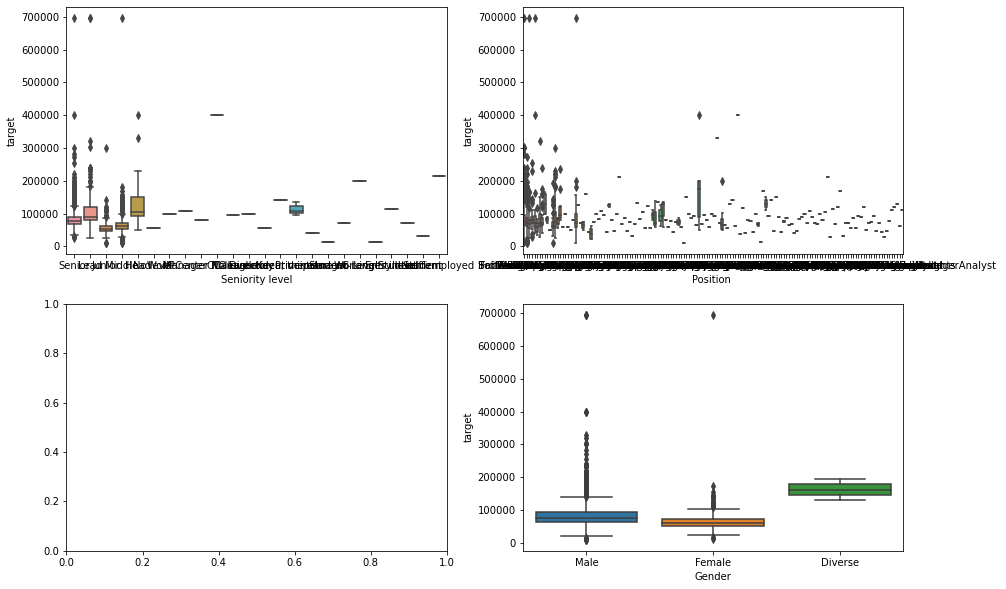

In [521]:
import seaborn as sns
import matplotlib.pyplot as plt


### Categorical Plotting
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.boxplot(x='Seniority level',y='target',data=df,ax=ax[0,0])
sns.boxplot(x='Position ',y='target',data=df ,ax=ax[0,1])
sns.boxplot(x='Gender',y='target',data=df ,ax=ax[1,1])

In [522]:
#Imputing numerical variables, filling the missing values with Median of the data.
df['Age']=df['Age'].fillna(df['Age'].median())
df['target']=df['target'].fillna(df['target'].median())
df['Years of experience in Germany']=df['Years of experience in Germany'].fillna(df['Years of experience in Germany'].median())


In [523]:
#Imputing for categorical variables, filling the missing values with the mode of the data.
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['City']=df['City'].fillna(df['City'].mode()[0])
df['Position ']=df['Position '].fillna(df['Position '].mode()[0])
df['Seniority level']=df['Seniority level'].fillna(df['Seniority level'].mode()[0])
df['Your main technology / programming language']=df['Your main technology / programming language'].fillna(df['Your main technology / programming language'].mode()[0])
df['Company size']=df['Company size'].fillna(df['Company size'].mode()[0])
df['Company type']=df['Company type'].fillna(df['Company type'].mode()[0])
df['Main language at work']= df['Main language at work'].fillna(df['Main language at work'].mode()[0])



### DEALING WITH ALL THE COLUMNS THAT HAVE LOW FREQUENT VALUES AND REMOVING THOSE VALUES

In [524]:
counts7 = df['Gender'].value_counts()

# Filter the values with count < 10
filtered_values7 = counts7[counts7 >= 10].index

# Replace the column with the filtered values
df.loc[~df['Gender'].isin(filtered_values7), 'Gender'] = None

In [525]:
counts = df['City'].value_counts()

# Filter the values with count < 10
filtered_values = counts[counts >= 10].index

# Replace the column with the filtered values
df.loc[~df['City'].isin(filtered_values), 'City'] = None

In [526]:
counts1 = df['Position '].value_counts()

# Filter the values with count < 10
filtered_values1 = counts1[counts1 > 5].index

# Replace the column with the filtered values
df.loc[~df['Position '].isin(filtered_values1), 'Position '] = None

In [527]:
counts2 = df['Seniority level'].value_counts()

# Filter the values with count < 10
filtered_values2 = counts2[counts2 > 2].index

# Replace the column with the filtered values
df.loc[~df['Seniority level'].isin(filtered_values2), 'Seniority level'] = None

In [528]:
counts3 = df['Company type'].value_counts()

# Filter the values with count < 10
filtered_values3 = counts3[counts3 > 2].index

# Replace the column with the filtered values
df.loc[~df['Company type'].isin(filtered_values3), 'Company type'] = None

In [529]:
counts4 = df['Main language at work'].value_counts()

# Filter the values with count < 10
filtered_values4 = counts4[counts4 > 2].index

# Replace the column with the filtered values
df.loc[~df['Main language at work'].isin(filtered_values4), 'Main language at work'] = None

In [530]:
counts6 = df['Company type'].value_counts()

# Filter the values with count < 10
filtered_values6 = counts6[counts6 > 3].index

# Replace the column with the filtered values
df.loc[~df['Company type'].isin(filtered_values6), 'Company type'] = None

In [531]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier 

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
#### Model
df2 = pd.get_dummies(df, drop_first=True)
y = df2["target"]
X = df2.drop(columns={"target"})

X_train, X_test, y_train, y_test = train_test_split(X, y)




clf = DecisionTreeRegressor(random_state=4) # changing
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.get_depth())
print(clf.score(X_test, y_test))
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
print(X.shape, y.shape)

29
-0.5777913342745011
Mean Squared Error:  3806137773.913997
RMSE: 61693.90386346124
(1253, 54) (1253,)


In [532]:
df.dropna(inplace=True)

In [535]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 1252
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Age                                          875 non-null    float64
 1   Gender                                       875 non-null    object 
 2   City                                         875 non-null    object 
 3   Position                                     875 non-null    object 
 4   Years of experience in Germany               875 non-null    float64
 5   Seniority level                              875 non-null    object 
 6   Your main technology / programming language  875 non-null    object 
 7   Main language at work                        875 non-null    object 
 8   Company size                                 875 non-null    object 
 9   Company type                                 875 non-null    object 
 10  t

In [536]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd


y = df["target"]
X= df.drop("target", axis=1)

# Define the numerical and categorical features


numerical_features = ['Age', 'Years of experience in Germany']
categorical_features = ['Gender','City','Position ','Seniority level','Your main technology / programming language',
 'Main language at work','Company size','Company type']

# Create a pipeline for numerical data
num_pipeline = Pipeline([('scaler', MinMaxScaler())])

# Create a pipeline for categorical data
cat_pipeline = Pipeline([('onehot', OneHotEncoder())])

# Combine the numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

# Define the feature selection step
feature_selector = SelectKBest(score_func=f_regression)


# Define the model

model = DecisionTreeRegressor()


# Create the pipeline with pre-processing, feature selection, and model steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('feature_selector', feature_selector),
                           ('model', model)])


# Define the hyperparameters for grid search
param_grid = {'feature_selector__k': [1, 2, 3, 4],
              'model__max_depth': [4, 5,6, 10, 15]}


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Evaluate the model on the testing data
score = grid_search.score(X_test, y_test.ravel())
print(f"R-squared score: {score:.2f}")
y_pred = grid_search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE',rmse)

# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)


R-squared score: -0.01
RMSE 77789.02527023843
Best parameters:  {'feature_selector__k': 1, 'model__max_depth': 4}


### DecisionTreeRegressor as the model
<br>GridSearchCV to tune the hyperparameters.
<br> We also use SelectKBest to select the top K features based on the F-statistic. 
<br>We define two preprocessing pipelines for the categorical and numerical features, and then combine them into one pipeline using ColumnTransformer.

In [534]:
#num_features = X.select_dtypes(exclude="object").columns
#cat_features = X.select_dtypes(include="object").columns


# Answers and Explainations
(Expand/modify as needed)

## Results

### Before  Feature Selection and GridSearchCV

### After  Feature Selection and GridSearchCV


## Feature Selection Activities

<br> -We also use SelectKBest to select the top K features based on the F-statistic. 
<br>The F-statistic is a measure of the overall fit of a linear regression model.It measures the ratio of the explained variance to the unexplained variance in the model. When performing feature selection in linear regression models, the F-statistic can be used to identify the top K features that are most important for predicting the target variable
<br>We define two preprocessing pipelines for the categorical and numerical features, and then combine them into one pipeline using ColumnTransformer

## Hyperparameter Changes
<br>GridSearchCV to tune the hyperparameters.
By systematically testing different combinations of hyperparameters, it helps to reduce the amount of trial and error required to find the optimal set of hyperparameters.